In [56]:
import numpy as np
import qutip as qt
from qutip import *
import matplotlib.pyplot as plt
from scipy.special import eval_hermite, factorial

In [91]:
N = 30
hbar = 1
x = np.linspace(-5,5,100)
p = np.linspace(-5,5,100)


# Create the quadrature eigenstate |p = p_val⟩ as a superposition in Fock basis
def p_eigenstate(p_val=0.0, N=1):
    # Position-space quadrature eigenstates in Fock basis (using known expression)
    # |p⟩ = sum_n ψ_n(p) |n⟩
    coeffs = []
    for n in range(N):
        Hn = eval_hermite(n, p_val)  # Hermite polynomial H_n(p)
        norm = 1.0 / (np.pi**0.25 * np.sqrt(2.0**n * factorial(n)))
        psi_n = norm * Hn * np.exp(-p_val**2 / 2)
        coeffs.append((1j)**n * psi_n)  # transform to p-basis from x-basis
    return qt.Qobj(coeffs, dims=[[N], [1]])  # column vector

class sq_cat_state:
    def __init__(self, N, k=1, alpha=1, r = 0):
        self.N = N
        self.k = k
        self.alpha = alpha
        self.r = r

    def state(self):
        S = qt.squeeze(self.N, self.r)
        return S * (qt.coherent(self.N, self.alpha) + (-1)**self.k * qt.coherent(self.N, -self.alpha)).unit()
    

def BS(N, eta, rho1, rho2):
    theta = np.arccos(np.sqrt(eta))

    # Single-mode operators
    a = qt.destroy(N)
    adag = a.dag()
    x_op = (a + adag) / np.sqrt(2)
    p_op = (a - adag) / (1j * np.sqrt(2))
    I = qt.qeye(N)

    # Operators acting on two-mode space
    x1 = qt.tensor(x_op, I)
    x2 = qt.tensor(I, x_op)
    p1 = qt.tensor(p_op, I)
    p2 = qt.tensor(I, p_op)

    U = (1j * theta * (p1 * x2 - x1 * p2)).expm()
    # Create the joint state
    joint_state = qt.tensor(rho1, rho2)
    rho_out = U * joint_state * U.dag()
    return rho_out


def p_quad_mode_1(N, p_val, rho_out):
    # Create |p=0⟩
    p0_ket = p_eigenstate(p_val, N=N)

    # Make the projector |p=0⟩⟨p=0|
    P_p0 = p0_ket * p0_ket.dag()
    P1 = qt.tensor(P_p0, qt.qeye(N))

    # Unnormalized post-measurement state
    rho_post = P1 * rho_out * P1.dag()

    # Probability of measuring p = 0
    prob = rho_post.tr()

    # Trace out mode 1 to get the conditional state of mode 2
    rho2_post = rho_post.ptrace(1) / prob
    return rho2_post

# Breeding with 2 beamsplittings
def breeding(N, etas, input_rhos):
    n = len(etas)
    current = input_rhos[0]
    for i in range(n):
        bs_state = BS(N, etas[0], current, input_rhos[i+1])
        post_state2 = p_quad_mode_1(N, 0.0, bs_state)
        current = post_state2
    return current



<>:34: SyntaxWarning: invalid escape sequence '\D'
<>:34: SyntaxWarning: invalid escape sequence '\D'
C:\Users\alexa\AppData\Local\Temp\ipykernel_100\1278657018.py:34: SyntaxWarning: invalid escape sequence '\D'
  axs[1,0].set_title(" $\Delta_x={}$, $\Delta_p=\Delta_x$, N = {}, BS's = {}".format(np.exp(-r), N, m-1))


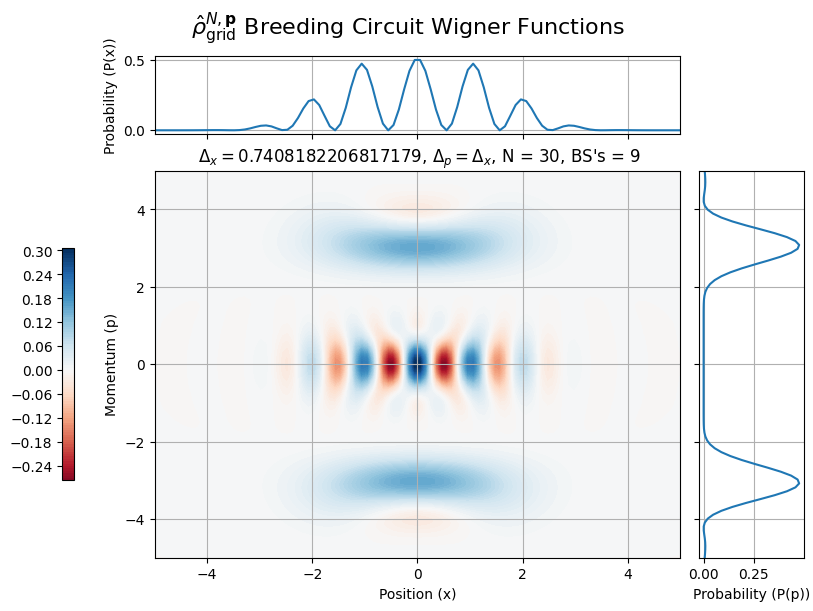

In [114]:
k, alpha, r = 1, 1, 0.3
rho1 = sq_cat_state(N, k, alpha, r).state() * sq_cat_state(N, k, alpha, r).state().dag()

m = 10 # number of input modes
rhos = [rho1]*m
etas = 1 / np.arange(2,m+1)
wig_out = breeding(N, etas, rhos)
W = qt.wigner(wig_out, x, p)

# Probs
Px = np.trapezoid(W, p, axis=0)  
Pp = np.trapezoid(W, x, axis=1)
vmin = np.min(W)
vmax = np.max(W)
vlim = np.max([np.abs(vmax), np.abs(vmin)])


# Plot

fig, axs = plt.subplots(2, 2, figsize=(8, 6), constrained_layout=True, gridspec_kw={"height_ratios": [0.2, 1], "width_ratios": [1, 0.2]}, sharex = "col", sharey = "row")

plt.suptitle(r"$\hat{\rho}_{\mathrm{grid}}^{N,\bf{p}}$ Breeding Circuit Wigner Functions", fontsize=16)

axs[0, 0].plot(x,Px)
axs[0, 0].set_ylabel("Probability (P(x))")
axs[0,0].grid()

#axs[0, 0].set_title("Top-left")

axs[0, 1].axis('off')  # disables axes for this cell

cf3 = axs[1,0].contourf(x, p, W, levels=100, cmap='RdBu', vmin = -vlim, vmax = vlim)

axs[1,0].set_title(" $\Delta_x={}$, $\Delta_p=\Delta_x$, N = {}, BS's = {}".format(np.exp(-r), N, m-1))
axs[1,0].set_xlabel("Position (x)")
axs[1,0].set_ylabel("Momentum (p)")
axs[1,0].grid()
fig.colorbar(cf3, ax=axs[1,0], location = 'left', shrink = 0.6)

axs[1, 1].plot(Pp,p)
axs[1, 1].set_xlabel("Probability (P(p))")
axs[1, 1].grid()
fig.savefig("breeding_wigner.jpg_0", dpi=300, format='png')